## Theoretical Background  
### Adversarial Robustness in Image Classification  
Deep neural networks, while highly effective in visual recognition tasks, are vulnerable to **adversarial attacks** — carefully crafted perturbations to input data that can cause models to make incorrect predictions. These perturbations are often imperceptible to humans but can dramatically reduce a model’s performance, exposing critical weaknesses in deep learning systems used in autonomous vehicles, surveillance, and security applications.  

One of the most widely studied attack methods is the **Fast Gradient Sign Method (FGSM)**, which generates adversarial examples by adjusting each input pixel in the direction of the gradient of the loss function with respect to the input image. This reveals how sensitive a model is to small but targeted changes in input data, providing valuable insights into its robustness.  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt


## Problem Statement  
The objective of this experiment is to **evaluate the adversarial vulnerability** of a simple convolutional neural network (CNN) designed to distinguish between “car” and “non-car” images in a synthetic dataset. The pipeline demonstrates how even a simple vision model trained on controlled data can be deceived by adversarial perturbations.  

---

## Methodology  
### Synthetic Dataset Generation  
A custom dataset is created where each 32×32 RGB image represents one of two classes:  
- **Class 0 (no_car):** Random pixel noise representing background scenes.  
- **Class 1 (car):** Images containing a bright rectangular region in the center, simulating the presence of a car.  

This dataset allows controlled experimentation without the complexity of real-world images.  


In [2]:
# ---- Synthetic Dataset ----
class SyntheticCarDataset(Dataset):
    """
    Generates simple 32x32 RGB images:
    - Class 0 (no_car): random noise.
    - Class 1 (car): centered bright rectangle (simulating a 'car' pattern).
    """
    def __init__(self, n_samples=1000, img_size=32, transform=None):
        self.n_samples = n_samples
        self.img_size = img_size
        self.transform = transform

        self.images = []
        self.labels = []

        for i in range(n_samples):
            label = np.random.randint(0, 2)
            img = np.random.rand(3, img_size, img_size) * 0.3  # background noise
            if label == 1:
                # draw a bright rectangle as "car"
                start = img_size // 4
                end = 3 * img_size // 4
                img[:, start:end, start:end] += 0.7  # brighter center
            img = np.clip(img, 0, 1)
            self.images.append(img.astype(np.float32))
            self.labels.append(label)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        x = self.images[idx]
        y = self.labels[idx]
        x = torch.tensor(x)
        if self.transform:
            x = self.transform(x)
        return x, torch.tensor(y, dtype=torch.long)

### Model Architecture  
A lightweight **convolutional neural network (CNN)** is trained for binary classification. The model includes two convolutional layers with ReLU activation, max pooling for spatial downsampling, and a fully connected output layer producing logits for the two classes.  

In [3]:
# ---- Model ----
class SimpleCarClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * (32 // 4) * (32 // 4), 2)
        )

    def forward(self, x):
        return self.net(x)

### Training and Evaluation  
The model is trained using the **Adam optimizer** and **cross-entropy loss** on batches of synthetic images. Training and testing accuracies are monitored to evaluate the classifier’s performance on clean data.  

### Adversarial Attack (FGSM)  
After training, the model is subjected to an **FGSM adversarial attack**. For each input image, the attack computes the gradient of the loss with respect to the input and adds a small perturbation (`ε`) in the direction of the gradient’s sign. The perturbed images are then re-evaluated by the model to measure performance degradation.  

In [4]:
# ---- Adversarial Attack (FGSM) ----
def adversarial_fgsm(model, x, y, eps=0.02):
    """
    Fast Gradient Sign Method (FGSM) Attack.
    """
    x.requires_grad = True
    logits = model(x)
    loss = nn.CrossEntropyLoss()(logits, y)
    model.zero_grad()
    loss.backward()
    adv_x = x + eps * x.grad.sign()
    return torch.clamp(adv_x, 0.0, 1.0)

# ---- Training & Evaluation ----
def train_classifier(model, loader, optimizer, device):
    model.train()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        loss.backward()
        optimizer.step()

def test_classifier(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total

### Visualization  
A comparison between original and adversarial examples illustrates how imperceptible changes can cause misclassification. Visualizations provide intuitive understanding of model vulnerability and the importance of robust training strategies.  

🚗 Training synthetic car classifier...
Epoch 1 | Clean test accuracy: 1.0000
Epoch 2 | Clean test accuracy: 1.0000
Epoch 3 | Clean test accuracy: 1.0000
Epoch 4 | Clean test accuracy: 1.0000
Epoch 5 | Clean test accuracy: 1.0000

Original preds: [0 1 1 1 1 0 1 1 0 0]
Adversarial preds: [0 1 1 1 1 0 1 1 0 0]


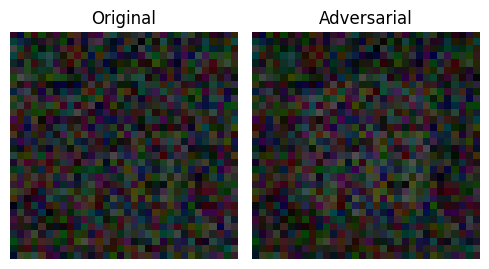

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate synthetic dataset
train_ds = SyntheticCarDataset(1500)
test_ds = SyntheticCarDataset(500)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

model = SimpleCarClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
print("🚗 Training synthetic car classifier...")
for epoch in range(5):
    train_classifier(model, train_loader, optimizer, device)
    acc = test_classifier(model, test_loader, device)
    print(f"Epoch {epoch+1} | Clean test accuracy: {acc:.4f}")

# Run FGSM adversarial attack on one batch
x0, y0 = next(iter(test_loader))
x0, y0 = x0.to(device), y0.to(device)
adv_x = adversarial_fgsm(model, x0, y0, eps=0.03)

with torch.no_grad():
    orig_preds = model(x0).argmax(dim=1).cpu().numpy()
    adv_preds = model(adv_x).argmax(dim=1).cpu().numpy()

print("\nOriginal preds:", orig_preds[:10])
print("Adversarial preds:", adv_preds[:10])

# Visualize example
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

orig_img = x0[idx].detach().cpu().numpy().transpose(1, 2, 0)
adv_img = adv_x[idx].detach().cpu().numpy().transpose(1, 2, 0)

axes[0].imshow(orig_img)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(adv_img)
axes[1].set_title("Adversarial")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Computational Challenge  
While this simplified framework highlights the principles of adversarial vulnerability, scaling to real-world autonomous systems presents major challenges. Real vehicle perception models process high-dimensional, dynamic scenes where adversarial attacks could exploit subtle patterns across time and space. Therefore, improving **robustness, generalization, and defense mechanisms** remains a critical direction for research in safe AI-driven perception systems.